In [22]:
import sys
sys.path.append("../../")
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
import plotly.express as px
from functions.eda import *
from functions.cat_eda import *
from functions.basic_cleaning import *
from functions.num_eda import *
from functions.pipeline_helpers import *

In [23]:
train_data=pl.read_csv("train_featureEngineered.csv").pipe(reduce_memory_usage)
test_data=pl.read_csv("test_featureEngineered.csv").pipe(reduce_memory_usage)
train_data.head()

customerID,SeniorCitizen,tenure,MultipleLines,InternetService,TechSupport,Contract,MonthlyCharges,TotalCharges,Churn,StreamersWithTechSupport,Safer,Family,OnlinePayment,All,ExpectedRechargeTimes,MonthlyChargesBin
str,i8,i8,i8,i8,i8,i8,f32,f32,i8,i8,i8,i8,i8,i8,f32,i8
"""6352-TWCAU""",0,35,1,0,0,1,86.449997,3029.100098,1,1,0,0,1,0,35.0,1
"""9700-ZCLOT""",0,2,0,2,0,1,20.0,32.700001,0,0,0,0,0,0,2.0,0
"""8070-AAWZP""",1,24,0,1,1,1,34.25,828.200012,0,0,0,0,0,0,24.0,0
"""6980-CDGFC""",0,67,0,2,0,12,20.85,1327.400024,0,0,0,0,0,0,5.583333,0
"""5536-SLHPM""",0,55,1,0,0,1,77.75,4458.149902,1,0,0,0,1,0,55.0,1


In [24]:
ratio=len(train_data.filter(train_data["Churn"]==1))/(len(train_data))
ratio

0.2649276543713063

In [25]:
from sklearn.metrics import (classification_report,classification_report)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,OneHotEncoder

cat_cols=[col for col in train_data.drop("customerID").columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("Churn").columns if train_data[col].dtype!= pl.String]

X_train=train_data.drop("customerID","Churn").to_pandas()
y_train=train_data["Churn"].to_pandas()
X_test=test_data.drop("customerID","Churn").to_pandas()
y_test=test_data["Churn"].to_pandas()

transformer = ColumnTransformer(
    [
        ("onehot", OneHotEncoder(handle_unknown="ignore",drop='first'), cat_cols),
        ("scaler", StandardScaler(), num_cols)
     ],
    remainder="passthrough",
)

pipe = Pipeline(
    [
        ("tranformer", transformer),
        ("classifier", LogisticRegression(class_weight={0:1,1:ratio*10})),
    ]
)
pipe

Pipeline(steps=[('tranformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  []),
                                                 ('scaler', StandardScaler(),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'TechSupport', 'Contract',
                                                   'MonthlyCharges',
                                                   'TotalCharges',
                                                   'StreamersWithTechSupport',
                                                   'Safer', 'Family',
                                                   'OnlinePayment', 'All',
                                                   'ExpectedRechargeTimes',
                                                   'MonthlyChargesBin'])])),
                ('classifier',
                 LogisticRegression(class_weight={0: 1,
                                                  1: 2.6492765437130625}))])

# Model evaluation

Mean Train roc auc Score: 0.8430558258155716
Standard Deviation of Train roc auc Scores: 0.0034227135594121372
Mean Train recall Score: 0.796156153596399
Standard Deviation of Train recall Scores: 0.009163464315856415

Mean Test roc auc Score: 0.8389637535112223
Standard Deviation of Test roc auc Scores: 0.007569816601677029
Mean Test recall Score: 0.7923086292303307
Standard Deviation of Test recall Scores: 0.006578615021694353
Area Under the Curve: 0.77
F1 Score: 0.64
Recall score: 0.79
precision : 0.53
logistic regression Accuracy: 0.76
Corr : 0.4872216793307242
              precision    recall  f1-score   support

           0       0.91      0.75      0.82      1548
           1       0.53      0.79      0.64       560

    accuracy                           0.76      2108
   macro avg       0.72      0.77      0.73      2108
weighted avg       0.81      0.76      0.77      2108



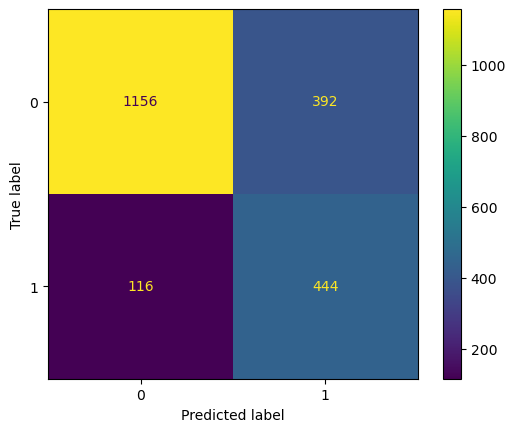

In [26]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score,f1_score,precision_score,accuracy_score,recall_score,matthews_corrcoef
from sklearn.model_selection import cross_validate,RepeatedStratifiedKFold
rskf = RepeatedStratifiedKFold(n_splits=3,n_repeats=3,random_state=42)
pipe.fit(X_train, y_train)

# Evaluation

cv_results = cross_validate(pipe, X_train,y_train, cv=rskf, scoring=['recall','roc_auc'],n_jobs=-1,return_train_score=True,error_score="raise")
# pipe.fit(X_train,y_train)
print(f'Mean Train roc auc Score: {cv_results["train_roc_auc"].mean()}')
print(f'Standard Deviation of Train roc auc Scores: {cv_results["train_roc_auc"].std()}')
print(f'Mean Train recall Score: {cv_results["train_recall"].mean()}')
print(f'Standard Deviation of Train recall Scores: {cv_results["train_recall"].std()}\n')

print(f'Mean Test roc auc Score: {cv_results["test_roc_auc"].mean()}')
print(f'Standard Deviation of Test roc auc Scores: {cv_results["test_roc_auc"].std()}')
print(f'Mean Test recall Score: {cv_results["test_recall"].mean()}')
print(f'Standard Deviation of Test recall Scores: {cv_results["test_recall"].std()}')
predictions= cross_val_predict(pipe,X_test,y_test,method='predict_proba',cv=3)
predictions=[0 if x < 0.5 else 1 for x in predictions[:,1]]
roc_auc = roc_auc_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
recall = recall_score(y_test,predictions)
precision = precision_score(y_test,predictions)
coef = matthews_corrcoef(y_test,predictions)
print(f"Area Under the Curve: {roc_auc:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"\033[1mRecall score: {recall:.2f}\033[0m")
print(f"precision : {precision:.2f}")
print(f"logistic regression Accuracy: {accuracy:.2f}")
print(f"Corr : {coef}")
print(classification_report(y_test,predictions))
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
fig=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,predictions))
fig.plot()

In [27]:
if hasattr(pipe.named_steps['classifier'], 'coef_'):
    feature_importances = pipe.named_steps['classifier'].coef_[0]
    feature_names = get_features(transformer)
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    print(importance_df)

                     Feature  Importance
7               TotalCharges    0.527651
11             OnlinePayment    0.239983
8   StreamersWithTechSupport    0.221362
2              MultipleLines    0.158496
12                       All    0.076578
0              SeniorCitizen    0.076263
10                    Family   -0.046375
9                      Safer   -0.048297
14         MonthlyChargesBin   -0.057268
4                TechSupport   -0.163977
13     ExpectedRechargeTimes   -0.310036
6             MonthlyCharges   -0.414560
1                     tenure   -0.794068
3            InternetService   -0.891276
5                   Contract   -1.086590


In [28]:
from imblearn.over_sampling import SMOTEN
sm=SMOTEN()
X_train_smote,y_train_smote=sm.fit_resample(X_train,y_train)
X_test_smote,y_test_smote=sm.fit_resample(X_test,y_test)

In [29]:
from sklearn.model_selection import cross_val_predict,RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score,f1_score,precision_score,accuracy_score,recall_score,matthews_corrcoef
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
rskf= RepeatedStratifiedKFold(n_repeats=3,n_splits=3,random_state=42)
param_distributions = {
    'classifier__C': Real(1e-6, 1e+6, prior='log-uniform'),
    'classifier__max_iter': Integer(100, 1000),
    'classifier__penalty': Categorical(['l1', 'l2']),
    'classifier__fit_intercept': Categorical([True, False]),
    
}

pipe_smote = Pipeline(
    [
        ("tranformer", transformer),
        ("classifier", LogisticRegression(random_state=42,solver='liblinear')),
    ]
)

search = BayesSearchCV(
    estimator=pipe_smote,
    search_spaces=param_distributions,
    n_iter=50)  

search.fit(X_train_smote, y_train_smote)
best_params = search.best_params_


pipe_smote.set_params(**best_params)
pipe_smote.fit(X_train_smote, y_train_smote)
# Evaluation
predictions_prob= cross_val_predict(pipe_smote,X_test_smote,y_test_smote,method='predict_proba',n_jobs=-1)
predictions=[0 if x < 0.5 else 1 for x in predictions_prob[:,1]]
roc_auc = roc_auc_score(y_test_smote, predictions)
f1 = f1_score(y_test_smote, predictions)
accuracy = accuracy_score(y_test_smote, predictions)
recall = recall_score(y_test_smote,predictions)
precision = precision_score(y_test_smote,predictions)
coef = matthews_corrcoef(y_test_smote,predictions)
print(f"Area Under the Curve: {roc_auc:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"\033[1mRecall score: {recall:.2f}\033[0m")
print(f"precision : {precision:.2f}")
print(f"logistic regression Accuracy: {accuracy:.2f}")
print(f"Corr : {coef}")
print(classification_report(y_test_smote,predictions))

Area Under the Curve: 0.82
F1 Score: 0.82
Recall score: 0.83
precision : 0.82
logistic regression Accuracy: 0.82
Corr : 0.6427875246644511
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1548
           1       0.82      0.83      0.82      1548

    accuracy                           0.82      3096
   macro avg       0.82      0.82      0.82      3096
weighted avg       0.82      0.82      0.82      3096



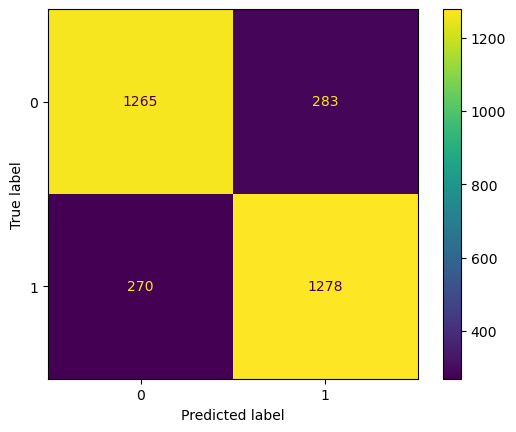

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
fig=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_smote,predictions))
fig.plot()

In [31]:
# from sklearn.model_selection import cross_val_predict, RepeatedStratifiedKFold
# from sklearn.metrics import roc_auc_score, f1_score, precision_score, accuracy_score, recall_score, matthews_corrcoef, classification_report
# from skopt import BayesSearchCV
# from skopt.space import Real, Categorical, Integer
# from xgboost import XGBClassifier
# from sklearn.pipeline import Pipeline

# rskf = RepeatedStratifiedKFold(n_repeats=3, n_splits=3, random_state=42)

# param_distributions = {
#     'classifier__n_estimators': Integer(100, 1000),
#     'classifier__max_depth': Integer(3, 10),
#     'classifier__learning_rate': Real(1e-6, 1e-1, prior='log-uniform'),
#     'classifier__subsample': Real(0.6, 1.0),
#     'classifier__colsample_bytree': Real(0.6, 1.0),
#     'classifier__gamma': Real(0, 5),
#     'classifier__reg_alpha': Real(0, 5),
#     'classifier__reg_lambda': Real(0, 5),
#     'classifier__scale_pos_weight': Real(1, 10)
# }

# pipe_smote = Pipeline(
#     [
#         ("transformer", transformer),
#         ("classifier", XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
#     ]
# )

# search = BayesSearchCV(
#     estimator=pipe_smote,
#     search_spaces=param_distributions,
#     n_iter=20,
#     cv=rskf,
#     n_jobs=-1,
#     random_state=42
# )

# search.fit(X_train_smote, y_train_smote)
# best_params = search.best_params_

# pipe_smote.set_params(**best_params)
# pipe_smote.fit(X_train_smote, y_train_smote)

# pipe_smote.fit(X_train_smote, y_train_smote)
# # Evaluation
# predictions= cross_val_predict(pipe_smote,X_test_smote,y_test_smote,method='predict_proba',n_jobs=-1)
# predictions=[0 if x < 0.5 else 1 for x in predictions[:,1]]
# roc_auc = roc_auc_score(y_test_smote, predictions)
# f1 = f1_score(y_test_smote, predictions)
# accuracy = accuracy_score(y_test_smote, predictions)
# recall = recall_score(y_test_smote,predictions)
# precision = precision_score(y_test_smote,predictions)
# coef = matthews_corrcoef(y_test_smote,predictions)
# print(f"Area Under the Curve: {roc_auc:.2f}")
# print(f"F1 Score: {f1:.2f}")
# print(f"\033[1mRecall score: {recall:.2f}\033[0m")
# print(f"precision : {precision:.2f}")
# print(f"Xg boost Accuracy: {accuracy:.2f}")
# print(f"Corr : {coef}")
# print(classification_report(y_test_smote,predictions))

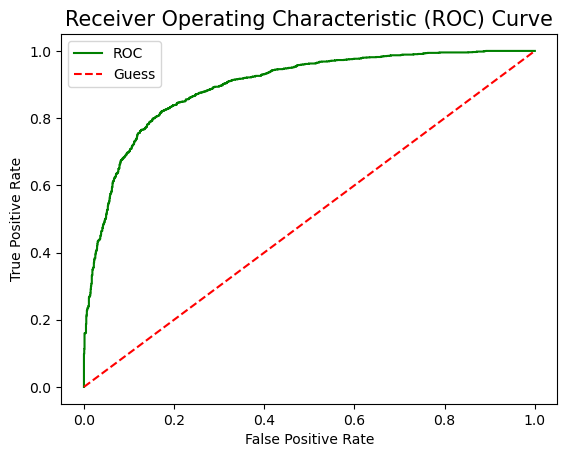

In [32]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds=roc_curve(y_test_smote,predictions_prob[:,1])
plot_roc_curve(fpr, tpr)

In [33]:
# df = pl.DataFrame(train_data[num_cols])

# means = df.mean()
# stds = df.std()

# # Broadcast means and stds to the entire DataFrame
# means_broadcasted = df.with_columns([pl.lit(means[col]).alias(col) for col in num_cols])
# stds_broadcasted = df.with_columns([pl.lit(stds[col]).alias(col) for col in num_cols])

# # Compute Z-scores
# df_z_scores = (df - means_broadcasted) / stds_broadcasted

# # Print the resulting DataFrame with Z-scores
# df_z_scores

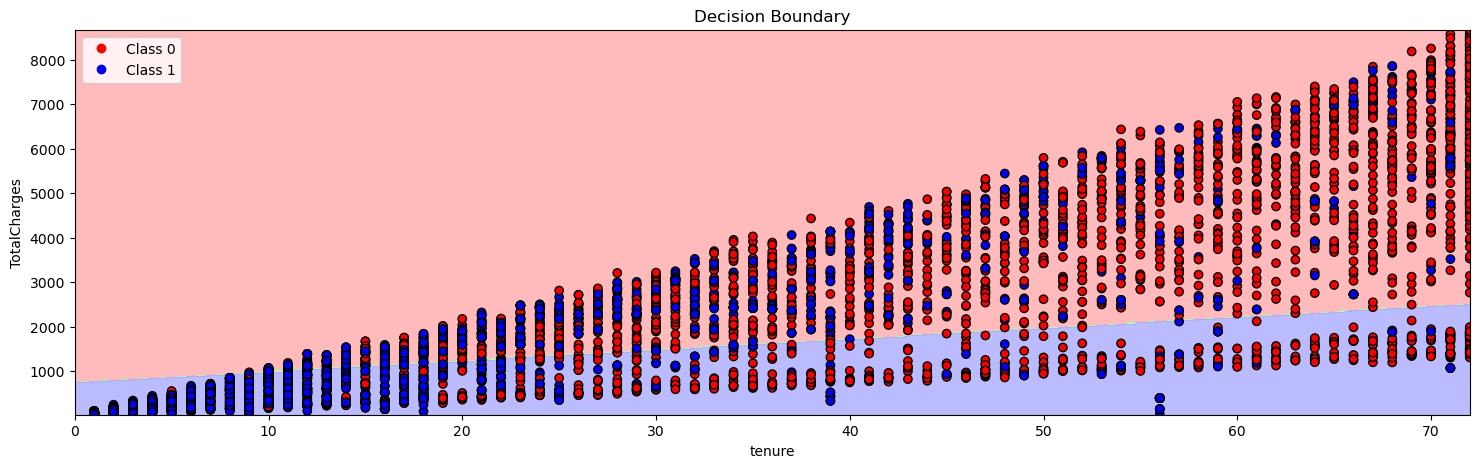

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Select two features (example: 'tenure' and 'MonthlyCharges')
feature1 = 'tenure'
feature2 = 'TotalCharges'
X_train_scaled = transformer.fit_transform(X_train)
X_test_scaled = transformer.transform(X_test)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Create a mesh grid
h = 1  # step size in the mesh
x_min, x_max = X_train[feature1].min() - 1, X_train[feature1].max() + 1
y_min, y_max = X_train[feature2].min() - 1, X_train[feature2].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Prepare the data for the prediction on the mesh grid
grid_data = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=[feature1, feature2])

# Add other features with default values to match the original dataset
for col in X_train.columns:
    if col not in [feature1, feature2]:
        grid_data[col] = X_train[col].mean()  # or some default value

# Apply the same transformations to the grid data
grid_data_transformed = transformer.transform(grid_data)

# Predict the classes for each point in the mesh grid
Z = pipe_smote.named_steps['classifier'].predict(grid_data_transformed)
Z = Z.reshape(xx.shape)

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ['#FF0000', '#00FF00', '#0000FF']

# Plot the decision boundary
plt.figure(figsize=(18, 5))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=cmap_light)

# Plot the training points
scatter = plt.scatter(X_train_smote[feature1], X_train_smote[feature2], c=y_train_smote, edgecolors='k', marker='o', cmap=ListedColormap(cmap_bold))
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title('Decision Boundary')

# Create a legend
handles = scatter.legend_elements()[0]
labels = ['Class 0', 'Class 1']
plt.legend(handles, labels)

plt.show()

In [35]:
# X_train_scaled = transformer.fit_transform(X_train_smote)
# X_test_scaled = transformer.transform(X_test_smote)

# import umap
# reducer = umap.UMAP(n_components=2,n_neighbors=10, random_state=42)
# embedding = reducer.fit_transform(X_train_scaled)
# X_umap=reducer.transform(X_test_scaled)
# embedding.shape

In [36]:
# plt.figure(figsize=(18, 5))
# colors = ['green' if pred == true else 'red' for pred, true in zip(predictions, y_test_smote)]

# plt.scatter(X_umap[:, 0], X_umap[:, 1], c=colors, marker='o', edgecolor='k', s=50)
# plt.title('UMAP of Test Data - Correct (green) and Misclassified (red)')
# plt.xlabel('UMAP Component 1')
# plt.ylabel('UMAP Component 2')

In [16]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# class_proportions = [0.264, 0.735]  # For example, class 0 has 30% and class 1 has 70% of the data
X_train_scaled = transformer.fit_transform(X_train_smote)
X_test_scaled = transformer.transform(X_test_smote)
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled,y_train_smote)

LinearDiscriminantAnalysis()

In [17]:
from sklearn.metrics import accuracy_score,classification_report,roc_curve,roc_auc_score
from sklearn.model_selection import cross_val_predict

predictions= cross_val_predict(lda,X_test_scaled,y_test_smote)

print("logistic regression accuracy :",accuracy_score(y_true=y_test_smote,y_pred=predictions))
print("auc roc",roc_auc_score(y_test_smote,predictions))
print(classification_report(y_test_smote,predictions))

logistic regression accuracy : 0.8268733850129198
auc roc 0.8268733850129198
              precision    recall  f1-score   support

           0       0.83      0.82      0.83      1548
           1       0.82      0.83      0.83      1548

    accuracy                           0.83      3096
   macro avg       0.83      0.83      0.83      3096
weighted avg       0.83      0.83      0.83      3096



In [43]:
from sklearn.metrics import roc_auc_score,f1_score,precision_score,accuracy_score,recall_score,matthews_corrcoef
# Evaluation
predictions_prob= cross_val_predict(lda,X_test_smote,y_test_smote,method='predict_proba')
predictions=[0 if x < 0.5 else 1 for x in predictions_prob[:,1]]
print("logistic regression accuracy :",accuracy_score(y_true=y_test_smote,y_pred=predictions))
print("auc roc",roc_auc_score(y_test_smote,predictions))
print(classification_report(y_test_smote,predictions))

logistic regression accuracy : 0.8229974160206718
auc roc 0.8229974160206719
              precision    recall  f1-score   support

           0       0.83      0.82      0.82      1548
           1       0.82      0.83      0.82      1548

    accuracy                           0.82      3096
   macro avg       0.82      0.82      0.82      3096
weighted avg       0.82      0.82      0.82      3096



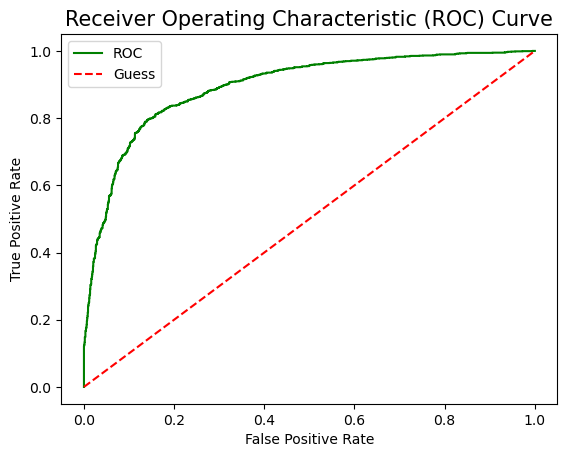

In [45]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds=roc_curve(y_test_smote,predictions_prob[:,1])
plot_roc_curve(fpr, tpr)